# Prediction using LSTM, GRU, xLSTM

In [1]:
import copy
import json
import pickle
import time
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pa
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from pandas import DataFrame
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from torch.utils.data import DataLoader, Subset

import thesis_utils.datastruc as tuds

In [2]:
# CONFIG GLOBALS
SAVE_ENABLED = True
SERIAL_NUMBER = "NOT_SET"
SEQ_LEN = 5
HORIZON = 1
BATCH_SIZE = 256
NUM_EPOCHS = 100
HIDDEN_SIZE = 128
N_LAYERS = 2
PATIENCE = 10
N_SPLITS = 3
RANDOM_SEED = 16
N_LAGS = 5
KEEP_FRAC = 1

## 3D Tensor Preparation

Pytorch expect a 3D Tensor.

In [13]:
processed = pa.read_parquet(path="../data/model/processed.parquet", engine="fastparquet")
df: DataFrame = processed.copy(deep=True)

In [14]:
"""
------ NORMALIZE DATA ------
- Normalize data with RobustScaler -> IMPORT, EXPORT, GDP_reporter, GDP_partner
"""
torch.manual_seed(RANDOM_SEED)
device = (
  torch.device("mps") if torch.backends.mps.is_available()
  else torch.device("cpu")
)

# Sort data to reproduce windows
df["dyad_id"] = df["ISO3_reporter"] + "_" + df["ISO3_partner"]
df = df.sort_values(by=["dyad_id", "Year"], ignore_index=True)

FEATURES: List[str] = [
  "GDP_reporter",
  "GDP_partner",
  "distw", "TOTAL", "arms", "military",
  "trade", "financial", "travel", "other", "contig", "comlang_off", "colony", "smctry",
  # "Year_feature",
  # "GDP_yearly_average",
]
df["Year_feature"] = df["Year"]
TARGET = "target_next"

# Calculate gravity_trade with the original scale
df["gravity_trade"] = np.log1p((df["GDP_reporter"] * df["GDP_partner"]) / df["distw"])
df["TOTAL"] = df["IMPORT"] + df["EXPORT"]

df["target_next"] = (
  df.groupby("dyad_id")["gravity_trade"]
  .shift(-1)
)

df = df.dropna(subset=["target_next"]).reset_index(drop=True)

In [15]:
# Scale data
scale_columns_minmax: List[str] = ["GDP_reporter", "GDP_partner", "TOTAL"]
scaler_rb = RobustScaler()
scaler_mm = MinMaxScaler()
df_scaled: DataFrame = df.copy(deep=True)
df_scaled[scale_columns_minmax] = scaler_mm.fit_transform(df[scale_columns_minmax])
df_scaled[["distw"]] = scaler_rb.fit_transform(df[["distw"]])

In [35]:
df_scaled

,ISO3_reporter,UNDS_reporter,CNAME_reporter,ISO3_partner,UNDS_partner,CNAME_partner,Year,GDP_reporter,GDP_partner,contig,...,travel,other,target_mult,sender_mult,GDP_yearly_average,dyad_id,Year_feature,gravity_trade,TOTAL,target_next
0,AGO,024,Angola,ALB,008,Albania,1988,0.000407,0.000095,False,...,0.0,0.0,0.0,0.0,1.169913e+11,AGO_ALB,1988,35.686523,0.000000,35.931627
1,AGO,024,Angola,ALB,008,Albania,1989,0.000473,0.000104,False,...,0.0,0.0,0.0,0.0,1.220728e+11,AGO_ALB,1989,35.931627,0.000000,35.922631
2,AGO,024,Angola,ALB,008,Albania,1990,0.000521,0.000094,False,...,0.0,0.0,0.0,0.0,1.275165e+11,AGO_ALB,1990,35.922631,0.000000,35.252882
3,AGO,024,Angola,ALB,008,Albania,1991,0.000492,0.000051,False,...,0.0,0.0,0.0,0.0,1.318462e+11,AGO_ALB,1991,35.252882,0.000000,34.486516
4,AGO,024,Angola,ALB,008,Albania,1992,0.000385,0.000030,False,...,0.0,0.0,0.0,0.0,1.406654e+11,AGO_ALB,1992,34.486516,0.000000,34.719221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065814,ZWE,716,Zimbabwe,ZMB,894,Zambia,2015,0.000926,0.000986,True,...,0.0,0.0,0.0,0.0,4.083473e+11,ZWE_ZMB,2015,41.127282,0.000540,41.142318
1065815,ZWE,716,Zimbabwe,ZMB,894,Zambia,2016,0.000954,0.000973,True,...,0.0,0.0,0.0,0.0,4.150802e+11,ZWE_ZMB,2016,41.142318,0.000373,42.263493
1065816,ZWE,716,Zimbabwe,ZMB,894,Zambia,2017,0.002371,0.001201,True,...,0.0,0.0,0.0,0.0,4.421821e+11,ZWE_ZMB,2017,42.263493,0.000269,41.877928
1065817,ZWE,716,Zimbabwe,ZMB,894,Zambia,2018,0.001585,0.001221,True,...,0.0,0.0,0.0,0.0,4.702892e+11,ZWE_ZMB,2018,41.877928,0.000356,41.472975


In [17]:
"""
----- Dataset and Split -----
"""

dataset = tuds.SlidingWindowDataset(
  data=df_scaled,
  features=FEATURES,
  target=TARGET,
  keep_frac=KEEP_FRAC
)

idx = np.arange(len(dataset))
train_idx, test_idx = train_test_split(
  idx, test_size=0.20, random_state=RANDOM_SEED
)
train_idx, val_idx = train_test_split(
  train_idx, test_size=0.20 / 0.80, random_state=RANDOM_SEED
)

train_loader = DataLoader(
  Subset(dataset, train_idx),
  batch_size=BATCH_SIZE,
  shuffle=True
)
print("Train loader ready")

val_loader = DataLoader(
  Subset(dataset, val_idx),
  batch_size=BATCH_SIZE,
  shuffle=False
)
print("Validation loader ready")

test_loader = DataLoader(
  Subset(dataset, test_idx),
  batch_size=BATCH_SIZE,
  shuffle=False
)
print("Test loader ready")

Train loader ready
Validation loader ready
Test loader ready


In [34]:
train_loader.dataset[0]

(tensor([[ 4.7330e-04,  1.0427e-04, -2.7557e-01,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 5.2101e-04,  9.3851e-05, -2.7557e-01,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 4.9196e-04,  5.0722e-05, -2.7557e-01,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 3.8537e-04,  2.9952e-05, -2.7557e-01,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 2.6749e-04,  5.4703e-05, -2.7557e-01,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00

## RANDOM FOREST (baseline)

In [8]:
HORIZONS = [1, 2, 3, 4, 5]
BASE_FEATS = FEATURES


def sample_dyads(df: DataFrame, frac: float = 0.20, seed: int = 16):
  rng = np.random.RandomState(seed)
  unique_dyads = df["dyad_id"].unique()
  k = int(len(unique_dyads) * frac)
  chosen = rng.choice(unique_dyads, size=k, replace=False)
  return df.loc[df["dyad_id"].isin(chosen)].copy()


df_scaled = sample_dyads(df_scaled, frac=0.20, seed=RANDOM_SEED)

print(f"Selected {df_scaled['dyad_id'].nunique()} dyads "
      f"out of {df_scaled['dyad_id'].nunique()} "
      f"({len(df_scaled):,} rows kept)")

for h in HORIZONS:
  df_scaled[f"target_next{h}"] = (
    df_scaled.groupby("dyad_id")["gravity_trade"].shift(-h)
  )
df_scaled.dropna(subset=[f"target_next{h}" for h in HORIZONS], inplace=True)

X_rows, Y_rows = [], []
for _, sub in df_scaled.groupby("dyad_id", sort=False):
  sub = sub.sort_values("Year")
  for i in range(len(sub) - SEQ_LEN - max(HORIZONS) + 1):
    win = sub.iloc[i: i + SEQ_LEN]
    flat = win[BASE_FEATS].to_numpy(np.float32).ravel()
    targets = [sub.iloc[i + SEQ_LEN + h - 1][f"target_next{h}"]
               for h in HORIZONS]
    X_rows.append(flat)
    Y_rows.append(targets)

X = np.stack(X_rows)
Y = np.stack(Y_rows)

X_tr, X_te, Y_tr, Y_te = train_test_split(
  X, Y, test_size=0.20, random_state=RANDOM_SEED
)

rf_base = RandomForestRegressor(
  n_estimators=400, max_depth=None,
  min_samples_leaf=1, n_jobs=-1,
  random_state=RANDOM_SEED
)
rf = MultiOutputRegressor(rf_base)

t0 = time.perf_counter()
rf.fit(X_tr, Y_tr)
print(f" RF fit   in {time.perf_counter() - t0:.2f}s   samples={len(X_tr)}")

t0 = time.perf_counter()
Y_pred = rf.predict(X_te)
print(f" RF predict in {time.perf_counter() - t0:.2f}s   samples={len(X_te)}")

for idx, h in enumerate(HORIZONS):
  r2 = r2_score(Y_te[:, idx], Y_pred[:, idx])
  print(f" Horizon +{h:>1d}y   R² = {r2:6.4f}")

Selected 6661 dyads out of 6661 (213,162 rows kept)
 RF fit   in 202.55s   samples=95926
 RF predict in 1.68s   samples=23982
 Horizon +1y   R² = 0.9921
 Horizon +2y   R² = 0.9874
 Horizon +3y   R² = 0.9831
 Horizon +4y   R² = 0.9800
 Horizon +5y   R² = 0.9795


## BASIC LSTM

In [18]:
"""
----- BASIC LSTM MODEL -----
"""


class BasicLSTM(nn.Module):
  def __init__(self,
               n_features: int,
               hidden_size: int = 128,
               n_layers: int = 2,
               dropout: float = 0.3):
    super(BasicLSTM, self).__init__()

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=hidden_size,
      num_layers=n_layers,
      dropout=dropout,
      batch_first=True,
    )
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, data):
    lstm_out, _ = self.lstm(data)
    h_last = lstm_out[:, -1, :]
    return self.fc(h_last).squeeze(1)


In [20]:
"""
---- K-FOLD ----
"""

kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)

best_fold_state = None
best_fold_rmse = float("inf")
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(dataset))), 1):
  print(f"=== FOLD {fold}/{N_SPLITS} ===")

  train_loader = DataLoader(
    Subset(dataset, train_idx),
    batch_size=BATCH_SIZE,
    shuffle=True
  )
  print("Train loader ready")

  val_loader = DataLoader(
    Subset(dataset, val_idx),
    batch_size=BATCH_SIZE,
    shuffle=False
  )
  print("Validation loader ready")

  model = BasicLSTM(n_features=len(FEATURES), n_layers=N_LAYERS, hidden_size=HIDDEN_SIZE).to(device=device)

  criterion = nn.MSELoss()
  optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=PATIENCE
  )

  best_state = copy.deepcopy(model.state_dict())
  best_rmse = float("inf")
  patience_left = PATIENCE

  for epoch in range(NUM_EPOCHS):
    model.train()
    for X, y, _ in train_loader:
      X = X.to(device)
      y = y.to(device)
      optimizer.zero_grad()
      loss = criterion(model(X), y)
      loss.backward()
      optimizer.step()

    model.eval()
    val_losses = []
    with (torch.no_grad()):
      for X, y, _ in val_loader:
        X = X.to(device)
        y = y.to(device)
        val_losses.append(criterion(model(X), y).item())

    val_rmse = (sum(val_losses) / len(val_losses)) ** 0.5
    scheduler.step(val_rmse)
    print(f"Epoch {epoch + 1:02d}  |  val RMSE: {val_rmse:.4f}")

    if val_rmse < best_rmse - 1e-4:
      best_rmse, patience_left = val_rmse, 10
      best_state = model.state_dict()
    else:
      patience_left -= 1
      if patience_left == 0:
        print("Early stop.")
        break

  model.load_state_dict(best_state)
  model.eval()
  preds, truth = [], []
  with torch.no_grad():
    for X, y, _ in val_loader:
      X = X.to(device)
      preds.append(model(X).cpu())
      truth.append(y)
  preds = torch.cat(preds).numpy()
  truth = torch.cat(truth).numpy()

  rmse = np.sqrt(((preds - truth) ** 2).mean())
  mae = np.abs(preds - truth).mean()
  r2 = 1 - ((preds - truth) ** 2).sum() / ((truth - truth.mean()) ** 2).sum()
  fold_metrics.append((rmse, mae, r2))
  print(f" Fold {fold}  RMSE {rmse:.4f} | MAE {mae:.4f} | R² {r2:.4f}")
  if rmse < best_fold_rmse:
    best_fold_rmse = rmse
    best_fold_state = copy.deepcopy(best_state)

rmse_avg = np.mean([m[0] for m in fold_metrics])
mae_avg = np.mean([m[1] for m in fold_metrics])
r2_avg = np.mean([m[2] for m in fold_metrics])
print(f"\n {N_SPLITS}‑fold mean  RMSE {rmse_avg:.4f} | MAE {mae_avg:.4f} | R² {r2_avg:.4f}")

=== FOLD 1/3 ===
Train loader ready
Validation loader ready
Epoch 01  |  val RMSE: 2.0115
Epoch 02  |  val RMSE: 1.7827
Epoch 03  |  val RMSE: 1.7220
Epoch 04  |  val RMSE: 1.6666
Epoch 05  |  val RMSE: 1.5624
Epoch 06  |  val RMSE: 1.5646
Epoch 07  |  val RMSE: 1.5160
Epoch 08  |  val RMSE: 1.6217
Epoch 09  |  val RMSE: 1.5123
Epoch 10  |  val RMSE: 1.5117
Epoch 11  |  val RMSE: 1.4768
Epoch 12  |  val RMSE: 1.4920
Epoch 13  |  val RMSE: 1.4786
Epoch 14  |  val RMSE: 1.4573
Epoch 15  |  val RMSE: 1.4835
Epoch 16  |  val RMSE: 1.4462
Epoch 17  |  val RMSE: 1.4305
Epoch 18  |  val RMSE: 1.4461
Epoch 19  |  val RMSE: 1.4424
Epoch 20  |  val RMSE: 1.4522
Epoch 21  |  val RMSE: 1.4207
Epoch 22  |  val RMSE: 1.4285
Epoch 23  |  val RMSE: 1.4140
Epoch 24  |  val RMSE: 1.3851
Epoch 25  |  val RMSE: 1.3940
Epoch 26  |  val RMSE: 1.4198
Epoch 27  |  val RMSE: 1.2782
Epoch 28  |  val RMSE: 1.1394
Epoch 29  |  val RMSE: 1.0466
Epoch 30  |  val RMSE: 1.1088
Epoch 31  |  val RMSE: 0.9589
Epoch 32  

In [19]:
SERIAL_NUMBER = f"BasicLSTM--L{N_LAYERS}H{HIDDEN_SIZE}E{NUM_EPOCHS}K{N_SPLITS}_v1(frac{KEEP_FRAC})"
if SAVE_ENABLED:
  torch.save(best_fold_state, f"../models/{SERIAL_NUMBER}_weights.pt")

  prep = {
    "minmax_scaler": scaler_mm,
    "robust_scaler": scaler_rb,
    "feature_cols": FEATURES,
  }
  with open(f"../models/{SERIAL_NUMBER}_pickle.pkl", "wb") as f:
    pickle.dump(prep, f)

  cfg = {
    "seq_len": SEQ_LEN,
    "horizon": HORIZON,
    "hidden_size": 128,
    "n_layers": 2,
    "dropout": 0.3,
    "batch_size": BATCH_SIZE,
    "n_splits": N_SPLITS,
    "features:": FEATURES,
  }
  with open(f"../models/{SERIAL_NUMBER}_config.json", "w") as f:
    json.dump(cfg, f, indent=2)

In [21]:
row_bank, preds_bank, truth_bank = [], [], []

model = BasicLSTM(n_features=len(FEATURES)).to(device)
model.load_state_dict(best_fold_state)
model.eval()

with torch.no_grad():
  for X, y, row_idx in test_loader:
    row_bank.append(row_idx.numpy())
    preds_bank.append(model(X.to(device)).cpu().numpy())
    truth_bank.append(y.numpy())

row_idx = np.concatenate(row_bank)
preds = np.concatenate(preds_bank)
truth = np.concatenate(truth_bank)
years = df_scaled.loc[row_idx, "Year"].values
df_plot = pa.DataFrame({
  "year": years.astype(int),
  "actual": np.expm1(truth),
  "pred": np.expm1(preds)
})

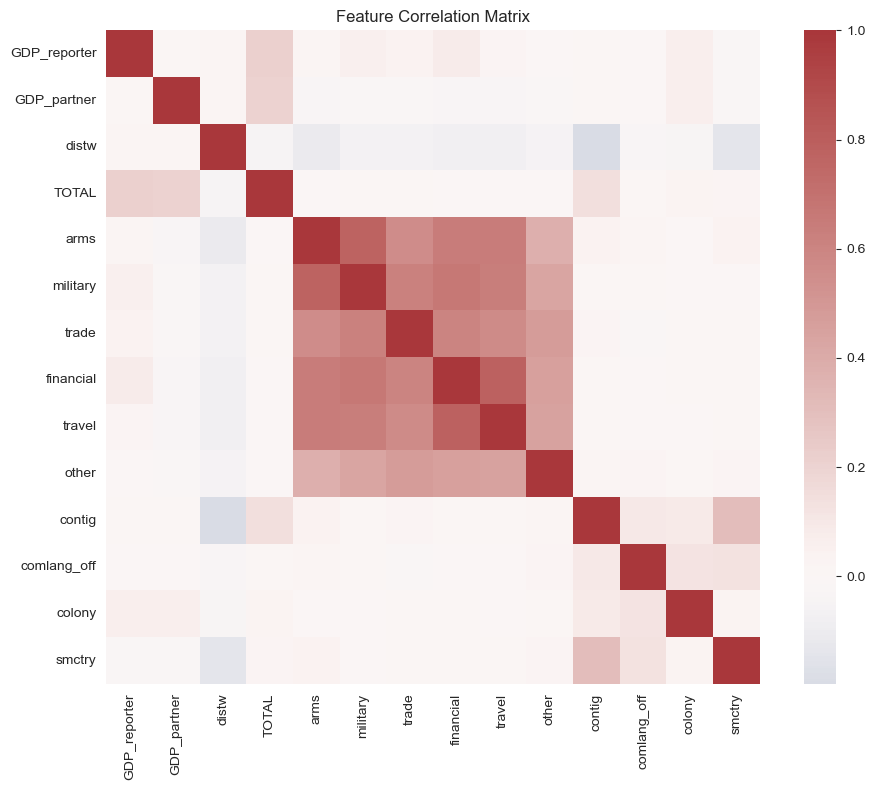

/var/folders/wz/kf7643gn3_s2867t_nnc9zxc0000gn/T/ipykernel_3292/3879591022.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp_df, x="delta_rmse", y="feature", palette="mako")
/var/folders/wz/kf7643gn3_s2867t_nnc9zxc0000gn/T/ipykernel_3292/3879591022.py:39: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
/opt/homebrew/Caskroom/miniconda/base/envs/thesis_env/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


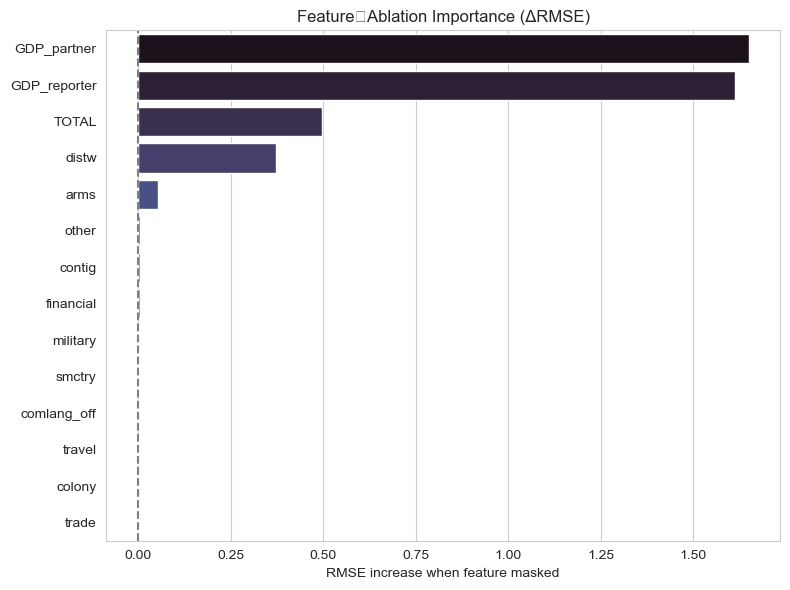

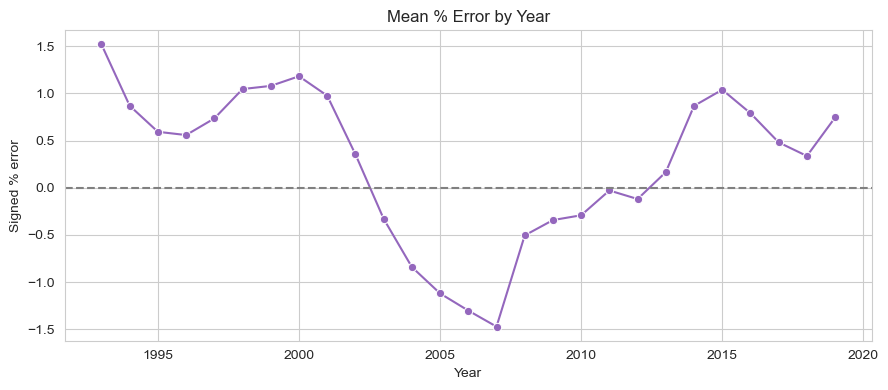

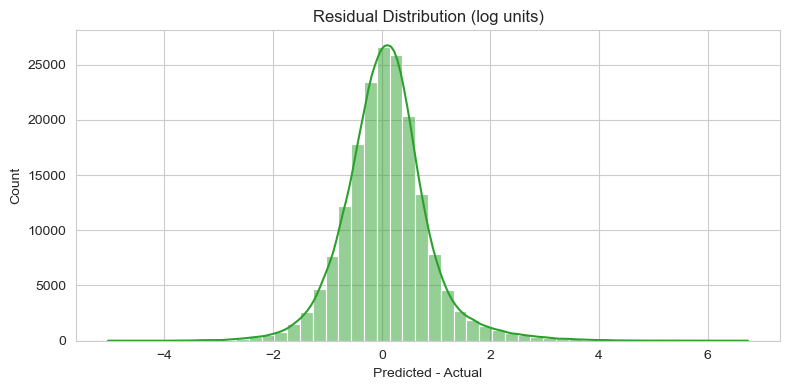

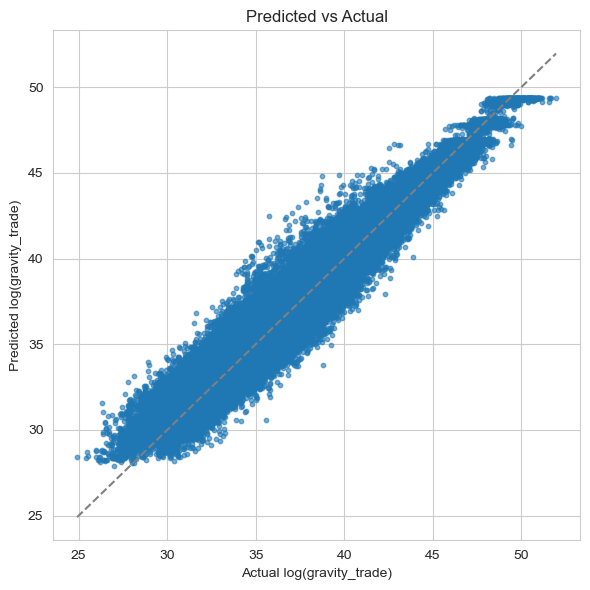

In [23]:
plt.figure(figsize=(10, 8))
corr = df_scaled[FEATURES].corr()
sns.heatmap(corr, cmap="vlag", center=0, square=True)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

X_list, y_list = [], []
for X, y, _ in test_loader:
  X_list.append(X.numpy())
  y_list.append(y.numpy())
X_test = np.concatenate(X_list)
y_test = np.concatenate(y_list)

with torch.no_grad():
  preds_orig = model(torch.from_numpy(X_test).to(device)).cpu().numpy()
orig_rmse = np.sqrt(((preds_orig - y_test) ** 2).mean())

importances = []
for i, feat in enumerate(FEATURES):
  X_mask = X_test.copy()
  X_mask[:, :, i] = X_mask[:, :, i].mean()
  with torch.no_grad():
    preds_mask = model(torch.from_numpy(X_mask).to(device)).cpu().numpy()
  rmse_mask = np.sqrt(((preds_mask - y_test) ** 2).mean())
  importances.append(rmse_mask - orig_rmse)

imp_df = pa.DataFrame({
  "feature": FEATURES,
  "delta_rmse": importances
}).sort_values("delta_rmse", ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(data=imp_df, x="delta_rmse", y="feature", palette="mako")
plt.axvline(0, color="gray", linestyle="--")
plt.title("Feature Ablation Importance")
plt.xlabel("RMSE increase when feature masked")
plt.ylabel("")
plt.tight_layout()
plt.show()

row_bank, preds_bank = [], []
truth_bank = []

with torch.no_grad():
  for X, y, row_idx in test_loader:
    preds_bank.append(model(X.to(device)).cpu().numpy())
    truth_bank.append(y.numpy())
    row_bank.append(row_idx.numpy())

preds_all = np.concatenate(preds_bank)
truth_all = np.concatenate(truth_bank)
rows_all = np.concatenate(row_bank)

years = df_scaled.loc[rows_all, "Year"].values
pct_err = 100 * (preds_all - truth_all) / truth_all

df_err = pa.DataFrame({ "year": years, "pct_err": pct_err })
mean_err = df_err.groupby("year")["pct_err"].mean().reset_index()

plt.figure(figsize=(9, 4))
sns.lineplot(data=mean_err, x="year", y="pct_err", marker="o", color="tab:purple")
plt.axhline(0, color="gray", linestyle="--")
plt.title("Mean % Error by Year")
plt.ylabel("Signed % error")
plt.xlabel("Year")
plt.tight_layout()
plt.show()

resid = preds_all - truth_all
plt.figure(figsize=(8, 4))
sns.histplot(resid, bins=50, kde=True, color="tab:green")
plt.title("Residual Distribution (log units)")
plt.xlabel("Predicted - Actual")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(truth_all, preds_all, s=10, alpha=0.6)
mn, mx = min(truth_all.min(), preds_all.min()), max(truth_all.max(), preds_all.max())
plt.plot([mn, mx], [mn, mx], color="gray", linestyle="--")
plt.xlabel("Actual log(gravity_trade)")
plt.ylabel("Predicted log(gravity_trade)")
plt.title("Predicted vs Actual")
plt.tight_layout()
plt.show()

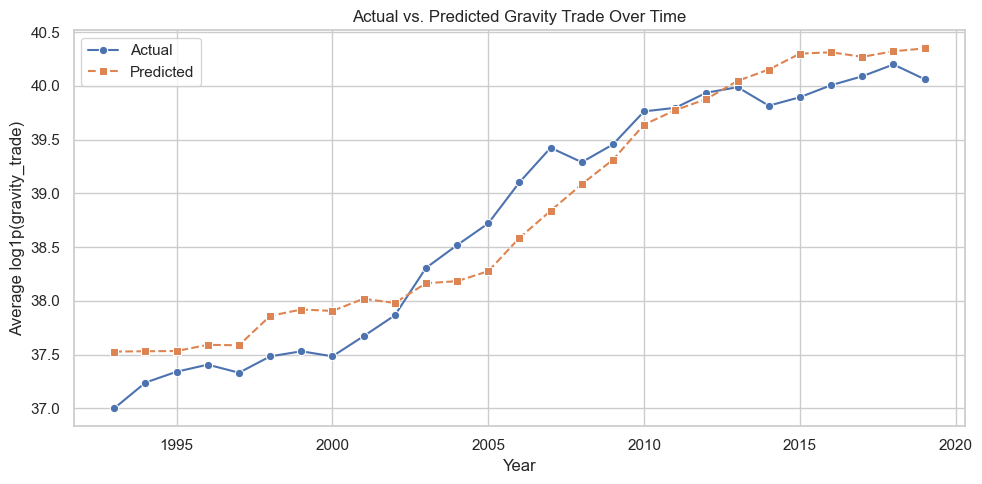

In [24]:
row_bank, preds_bank, truth_bank = [], [], []

model.eval()
with torch.no_grad():
  for X, y, row_idx in test_loader:
    preds_bank.append(model(X.to(device)).cpu().numpy())
    truth_bank.append(y.numpy())
    row_bank.append(row_idx.numpy())

row_idx = np.concatenate(row_bank)
preds = np.concatenate(preds_bank)
truth = np.concatenate(truth_bank)

years = df_scaled.loc[row_idx, "Year"].values

df_timeseries = pa.DataFrame({
  "year": years,
  "actual": truth,
  "predicted": preds
})

df_yearly = (
  df_timeseries
  .groupby("year", as_index=False)
  .agg(
    actual_mean=("actual", "mean"),
    predicted_mean=("predicted", "mean")
  )
)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 5))
sns.lineplot(
  data=df_yearly,
  x="year", y="actual_mean",
  marker="o", label="Actual"
)
sns.lineplot(
  data=df_yearly,
  x="year", y="predicted_mean",
  marker="s", linestyle="--", label="Predicted"
)
plt.xlabel("Year")
plt.ylabel("Average log1p(gravity_trade)")
plt.title("Actual vs. Predicted Gravity Trade Over Time")
plt.legend()
plt.tight_layout()
plt.show()

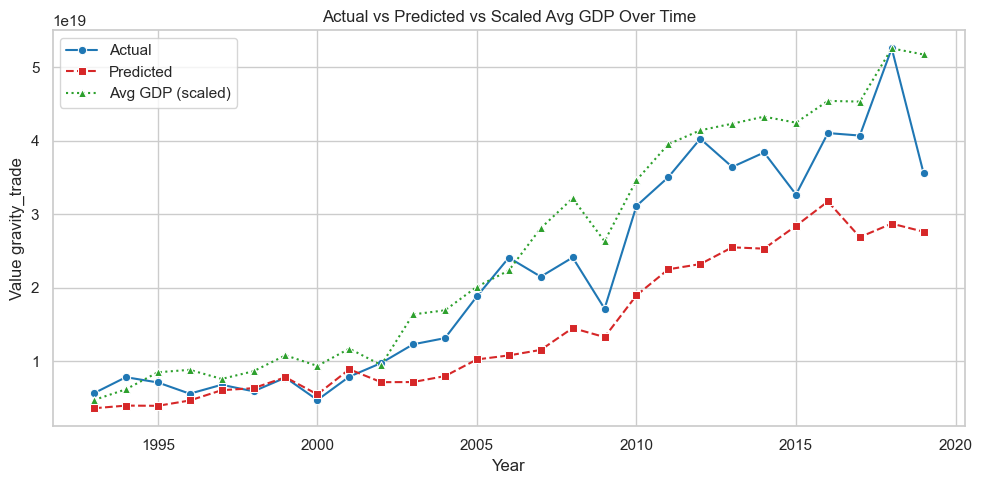

In [25]:
row_bank, preds_bank, truth_bank = [], [], []

model.eval()
with torch.no_grad():
  for X, y, row_idx in test_loader:
    preds_bank.append(model(X.to(device)).cpu().numpy())
    truth_bank.append(y.numpy())
    row_bank.append(row_idx.numpy())

row_idx = np.concatenate(row_bank)
preds = np.expm1(np.concatenate(preds_bank))
truth = np.expm1(np.concatenate(truth_bank))

years = df_scaled.loc[row_idx, "Year"].values
df_timeseries = pa.DataFrame({
  "year": years,
  "actual": truth,
  "predicted": preds
})

df_yearly = (
  df_timeseries
  .groupby("year", as_index=False)
  .agg(
    actual_mean=("actual", "mean"),
    predicted_mean=("predicted", "mean")
  )
)

gdp_df = df_scaled.loc[row_idx, ["Year", "GDP_reporter", "GDP_partner"]].copy()
gdp_df["gdp_avg"] = (gdp_df["GDP_reporter"] + gdp_df["GDP_partner"]) / 2

gdp_yearly = (
  gdp_df
  .groupby("Year", as_index=False)
  .agg(gdp_mean=("gdp_avg", "mean"))
  .rename(columns={ "Year": "year" })
)

scaler = MinMaxScaler(feature_range=(
  df_yearly["actual_mean"].min(),
  df_yearly["actual_mean"].max()
))
gdp_yearly["gdp_scaled"] = scaler.fit_transform(
  gdp_yearly[["gdp_mean"]]
)

df_plot = pa.merge(df_yearly, gdp_yearly[["year", "gdp_scaled"]], on="year")

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 5))

sns.lineplot(
  data=df_plot, x="year", y="actual_mean",
  marker="o", label="Actual", color="tab:blue"
)
sns.lineplot(
  data=df_plot, x="year", y="predicted_mean",
  marker="s", linestyle="--", label="Predicted", color="tab:red"
)
sns.lineplot(
  data=df_plot, x="year", y="gdp_scaled",
  marker="^", linestyle=":", label="Avg GDP (scaled)", color="tab:green"
)

plt.xlabel("Year")
plt.ylabel("Value gravity_trade")
plt.title("Actual vs Predicted vs Scaled Avg GDP Over Time")
plt.legend()
plt.tight_layout()
plt.show()

## BASIC GRU

In [26]:
"""
---- GRU LSTM ----
"""


class BasicGRU(nn.Module):
  def __init__(self, n_features: int, hidden_size: int = 128, output_dim: int = 1, n_layers: int = 2,
               dropout: float = 0.3):
    super(BasicGRU, self).__init__()
    self.hidden_dim = hidden_size
    self.n_layers = n_layers

    self.gru = nn.GRU(input_size=n_features,
                      hidden_size=hidden_size,
                      num_layers=n_layers,
                      batch_first=True,
                      dropout=dropout, )
    self.fc = nn.Linear(hidden_size, output_dim)

  def forward(self, data):
    out, _ = self.gru(data)
    h_last = out[:, -1, :]

    return self.fc(h_last).squeeze(1)



In [27]:
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)

best_fold_state = None
best_fold_rmse = float("inf")
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(dataset))), 1):
  print(f"=== FOLD {fold}/{N_SPLITS} ===")

  train_loader = DataLoader(
    Subset(dataset, train_idx),
    batch_size=BATCH_SIZE,
    shuffle=True
  )
  print("Train loader ready")

  val_loader = DataLoader(
    Subset(dataset, val_idx),
    batch_size=BATCH_SIZE,
    shuffle=False
  )
  print("Validation loader ready")

  model = BasicGRU(n_features=len(FEATURES), hidden_size=HIDDEN_SIZE, n_layers=N_LAYERS).to(device=device)

  criterion = nn.MSELoss()
  optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=PATIENCE
  )

  best_state = copy.deepcopy(model.state_dict())
  best_rmse = float("inf")
  patience_left = PATIENCE

  model.train()
  for epoch in range(NUM_EPOCHS):

    for X, y, _ in train_loader:
      X = X.to(device)
      y = y.to(device)
      optimizer.zero_grad()
      out = model(X)
      loss = criterion(out, y)
      loss.backward()
      optimizer.step()

    model.eval()
    val_losses = []
    with (torch.no_grad()):
      for X, y, _ in val_loader:
        X = X.to(device)
        y = y.to(device)
        val_losses.append(criterion(model(X), y).item())

    val_rmse = (sum(val_losses) / len(val_losses)) ** 0.5
    scheduler.step(val_rmse)
    print(f"Epoch {epoch + 1:02d}  |  val RMSE: {val_rmse:.4f}")

    if val_rmse < best_rmse - 1e-4:
      best_rmse, patience_left = val_rmse, 10
      best_state = model.state_dict()
    else:
      patience_left -= 1
      if patience_left == 0:
        print("Early stop.")
        break

  model.load_state_dict(best_state)
  model.eval()
  preds, truth = [], []
  with torch.no_grad():
    for X, y, _ in val_loader:
      X = X.to(device)
      preds.append(model(X).cpu())
      truth.append(y)
  preds = torch.cat(preds).numpy()
  truth = torch.cat(truth).numpy()

  rmse = np.sqrt(((preds - truth) ** 2).mean())
  mae = np.abs(preds - truth).mean()
  r2 = 1 - ((preds - truth) ** 2).sum() / ((truth - truth.mean()) ** 2).sum()
  fold_metrics.append((rmse, mae, r2))
  print(f" Fold {fold}  RMSE {rmse:.4f} | MAE {mae:.4f} | R² {r2:.4f}")
  if rmse < best_fold_rmse:
    best_fold_rmse = rmse
    best_fold_state = copy.deepcopy(best_state)

rmse_avg = np.mean([m[0] for m in fold_metrics])
mae_avg = np.mean([m[1] for m in fold_metrics])
r2_avg = np.mean([m[2] for m in fold_metrics])
print(f"\n {N_SPLITS}‑fold mean  RMSE {rmse_avg:.4f} | MAE {mae_avg:.4f} | R² {r2_avg:.4f}")

=== 🔌 FOLD 1/3 ===
✳️Train loader ready
✳️Validation loader ready
🌯 Epoch 01  |  val RMSE: 3.7683
🌯 Epoch 02  |  val RMSE: 3.7680
🌯 Epoch 03  |  val RMSE: 1.9356
🌯 Epoch 04  |  val RMSE: 1.6458
🌯 Epoch 05  |  val RMSE: 1.5341
🌯 Epoch 06  |  val RMSE: 1.5009
🌯 Epoch 07  |  val RMSE: 1.4969
🌯 Epoch 08  |  val RMSE: 1.4134
🌯 Epoch 09  |  val RMSE: 1.4418
🌯 Epoch 10  |  val RMSE: 1.4453
🌯 Epoch 11  |  val RMSE: 1.4264
🌯 Epoch 12  |  val RMSE: 1.2212
🌯 Epoch 13  |  val RMSE: 0.9787
🌯 Epoch 14  |  val RMSE: 0.8886
🌯 Epoch 15  |  val RMSE: 0.9350
🌯 Epoch 16  |  val RMSE: 1.0360
🌯 Epoch 17  |  val RMSE: 0.8137
🌯 Epoch 18  |  val RMSE: 0.7949
🌯 Epoch 19  |  val RMSE: 0.7953
🌯 Epoch 20  |  val RMSE: 0.8715
🌯 Epoch 21  |  val RMSE: 0.7443
🌯 Epoch 22  |  val RMSE: 0.7960


KeyboardInterrupt: 

In [367]:
SERIAL_NUMBER = f"BasicGRU--L{N_LAYERS}H{HIDDEN_SIZE}E{NUM_EPOCHS}K{N_SPLITS}_v1(frac{KEEP_FRAC})"
if SAVE_ENABLED:
  torch.save(best_fold_state, f"../models/{SERIAL_NUMBER}_weights.pt")

  prep = {
    "minmax_scaler": scaler_mm,
    "robust_scaler": scaler_rb,
    "feature_cols": FEATURES,
  }
  with open(f"../models/{SERIAL_NUMBER}_pickle.pkl", "wb") as f:
    pickle.dump(prep, f)

  cfg = {
    "seq_len": SEQ_LEN,
    "horizon": HORIZON,
    "hidden_size": 128,
    "n_layers": 2,
    "dropout": 0.3,
    "batch_size": BATCH_SIZE,
    "n_splits": N_SPLITS,
  }
  with open(f"../models/{SERIAL_NUMBER}_config.json", "w") as f:
    json.dump(cfg, f, indent=2)

In [379]:
model = BasicGRU(n_features=len(FEATURES)).to(device)
model.load_state_dict(best_fold_state)
model.eval()

rows, preds, truths = [], [], []
with torch.no_grad():
  for X, y, row_idx in test_loader:
    preds.append(model(X.to(device)).cpu().numpy())
    truths.append(y.numpy())
    rows.append(row_idx.numpy())

rows = np.concatenate(rows)
preds = np.concatenate(preds)
truths = np.concatenate(truths)
mae = mean_absolute_error(truth, preds)
mae

2.536288111962987e+19

In [380]:
print("Test set size:", len(test_loader.dataset))
batch = next(iter(test_loader))
print("Batch shapes:", [t.shape for t in batch[:2]], "rows:", batch[2].shape)

Test set size: 189027
Batch shapes: [torch.Size([256, 5, 14]), torch.Size([256])] rows: torch.Size([256])


In [381]:
def enable_dropout(m):
  if isinstance(m, torch.nn.Dropout):
    m.train()


model.eval()
model.apply(enable_dropout)

M = 50
all_preds, all_truths, all_rows = [], [], []
with torch.no_grad():
  for X, y, rows in test_loader:
    X = X.to(device)
    batch_samples = [model(X).cpu().numpy() for _ in range(M)]
    batch_preds = np.stack(batch_samples, axis=1)
    all_preds.append(batch_preds)
    all_truths.append(y.numpy())
    all_rows.append(rows.numpy())

all_preds = np.concatenate(all_preds, axis=0)
truths = np.concatenate(all_truths, axis=0)
rows = np.concatenate(all_rows, axis=0)

In [388]:
# (c) compute 95% intervals
pred_mean = all_preds.mean(axis=1)
pred_lower = np.percentile(all_preds, 0, axis=1)
pred_upper = np.percentile(all_preds, 97.5, axis=1)
print("Mean prediction shape:", pred_mean.mean())
print("Lower prediction shape:", pred_lower.mean())
print("Upper prediction shape:", pred_upper.mean())

Mean prediction shape: 38.90855
Lower prediction shape: 38.908554
Upper prediction shape: 38.908554


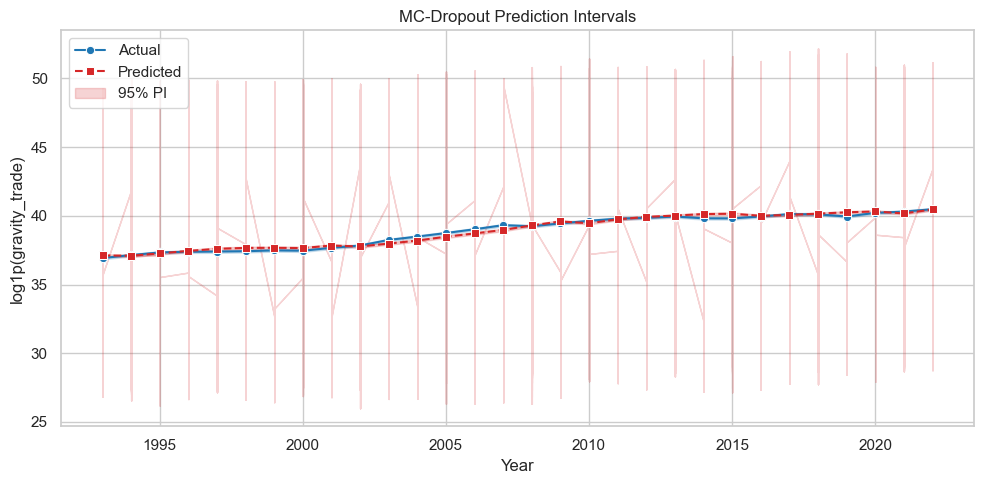

In [389]:
years = df_scaled.loc[rows, "Year"].values
df_plot = pa.DataFrame({
  "year": years,
  "actual": np.expm1(truths),
  "pred": np.expm1(pred_mean),
  "lower": np.expm1(pred_lower),
  "upper": np.expm1(pred_upper)
}).sort_values("year")

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_plot, x="year", y="actual",
             marker="o", label="Actual", color="tab:blue")
sns.lineplot(data=df_plot, x="year", y="pred",
             marker="s", linestyle="--", label="Predicted", color="tab:red")
plt.fill_between(df_plot["year"],
                 df_plot["lower"], df_plot["upper"],
                 color="tab:red", alpha=0.2, label="95% PI")
plt.xlabel("Year")
plt.ylabel("log1p(gravity_trade)")
plt.title("MC-Dropout Prediction Intervals")
plt.legend()
plt.tight_layout()
plt.show()

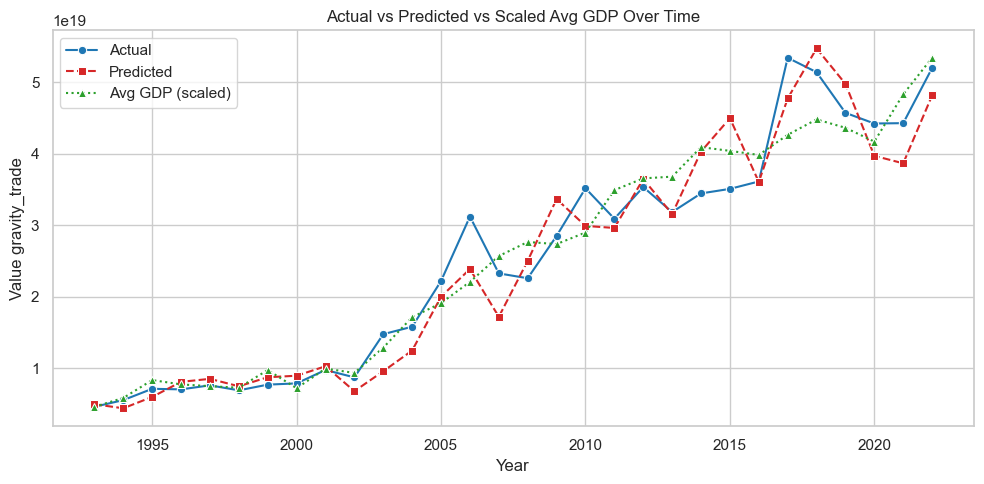

In [370]:
row_bank, preds_bank, truth_bank = [], [], []

model.eval()
with torch.no_grad():
  for X, y, row_idx in test_loader:
    preds_bank.append(model(X.to(device)).cpu().numpy())
    truth_bank.append(y.numpy())
    row_bank.append(row_idx.numpy())

row_idx = np.concatenate(row_bank)
preds = np.expm1(np.concatenate(preds_bank))
truth = np.expm1(np.concatenate(truth_bank))

years = df_scaled.loc[row_idx, "Year"].values

df_timeseries = pa.DataFrame({
  "year": years,
  "actual": truth,
  "predicted": preds
})

df_yearly = (
  df_timeseries
  .groupby("year", as_index=False)
  .agg(
    actual_mean=("actual", "mean"),
    predicted_mean=("predicted", "mean")
  )
)

gdp_df = df_scaled.loc[row_idx, ["Year", "GDP_reporter", "GDP_partner"]].copy()
gdp_df["gdp_avg"] = (gdp_df["GDP_reporter"] + gdp_df["GDP_partner"]) / 2

gdp_yearly = (
  gdp_df
  .groupby("Year", as_index=False)
  .agg(gdp_mean=("gdp_avg", "mean"))
  .rename(columns={ "Year": "year" })
)

scaler = MinMaxScaler(feature_range=(
  df_yearly["actual_mean"].min(),
  df_yearly["actual_mean"].max()
))
gdp_yearly["gdp_scaled"] = scaler.fit_transform(
  gdp_yearly[["gdp_mean"]]
)

df_plot = pa.merge(df_yearly, gdp_yearly[["year", "gdp_scaled"]], on="year")
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 5))

sns.lineplot(
  data=df_plot, x="year", y="actual_mean",
  marker="o", label="Actual", color="tab:blue"
)
sns.lineplot(
  data=df_plot, x="year", y="predicted_mean",
  marker="s", linestyle="--", label="Predicted", color="tab:red"
)
sns.lineplot(
  data=df_plot, x="year", y="gdp_scaled",
  marker="^", linestyle=":", label="Avg GDP (scaled)", color="tab:green"
)

plt.xlabel("Year")
plt.ylabel("Value gravity_trade")
plt.title("Actual vs Predicted vs Scaled Avg GDP Over Time")
plt.legend()
plt.tight_layout()
plt.show()